In [22]:
from tools.utils import *
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch
import spacy

# Prepare data for annotation

In [23]:
# prepare the spacy model and pipeline
nlp = spacy.load("en_core_web_sm")
nlp.disable_pipes("tagger", "parser", "attribute_ruler", "lemmatizer")
nlp.add_pipe('sentencizer')


In [24]:
processed_data_dir = Path('processed_data')

In [25]:
embeddings = np.loadtxt(processed_data_dir / 'embedding.tsv')
metadata = pd.read_csv(processed_data_dir / 'metadata.tsv',sep='\t')
print(len(embeddings), len(metadata))

105245 105245


In [26]:
examples_df = pd.read_excel('annotations/scraping_clauses.xlsx', sheet_name='Sheet1')

In [27]:
examples_df['processed_text'] = examples_df['No Scraping Clause'].apply(lambda x: 'clustering: ' + replace_named_entities(nlp(x)))

In [28]:
examples_df['processed_text']

0     clustering: scraping or replicating any part o...
1     clustering: you shall not yourself or through ...
2     clustering: do n’t use the services to do harm...
3     clustering: you may not access or collect data...
4     clustering: you will not use , sublicense , co...
5     clustering: you must not abuse , harm , interf...
6     clustering: you will not probe , scan , or tes...
7     clustering: you ca n't attempt to create accou...
8     clustering: do n’t use any kind of software or...
9     clustering: you agree that you will not : deve...
10    clustering: you agree that you will not [ ... ...
11    clustering: you agree that you will not , eith...
12    clustering: prohibited activity on , through ,...
13    clustering: in connection with your use of our...
14    clustering: you may not use viruses , spyware ...
15    clustering: you may not [ ... ] access , searc...
16    clustering: you may not do , attempt to do , e...
17    clustering: you may not [ … ] access or se

In [29]:
# next line is to check if MPS is available
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
# comment next line if you are want to run code on a GPU
#device = 'cuda' if torch.cuda.is_available() else device

# load the nomic embed model
model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True) # trust_remote_code is needed to use the encode method
# send the model to the device
model.to(device)
print(device)

/Users/kasparbeelen/anaconda3/envs/tou/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<All keys matched successfully>


mps


In [30]:
target_embeddings = model.encode(examples_df['processed_text'].tolist())

In [34]:
average_embedding = target_embeddings.mean(axis=0)

In [63]:
similarity_scores = cosine_similarity(embeddings, [average_embedding])
top_n_position = np.argpartition(similarity_scores.reshape(-1), -100)[-100:][::-1]
out_csv = pd.DataFrame(metadata.iloc[top_n_position].sentence.unique())
out_csv.columns = ['sentence']
out_csv['label'] = 0
#out_csv['similarity'] = similarity_scores[top_n_position]
out_csv.to_csv('annotations/most_similar_to_average.csv')

In [68]:
similarity_scores = cosine_similarity(embeddings, target_embeddings)
similarity_scores = similarity_scores.max(axis=1)
top_n_position = np.argpartition(similarity_scores, -100)[-100:][::-1]
out_csv = pd.DataFrame(metadata.iloc[top_n_position].sentence.unique())
out_csv.columns = ['sentence']
out_csv['label'] = 0
#out_csv['similarity'] = similarity_scores[top_n_position]
out_csv.to_csv('annotations/most_similar_to_individual.csv')

# Load annotations and train a classifier

In [8]:
import pandas as pd
from torch.utils.data import DataLoader
from pathlib import Path
import evaluate
from datasets import Dataset
from transformers import AdamW
from tqdm.auto import tqdm
from transformers import get_scheduler
from torch.nn.functional import softmax
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoTokenizer, DataCollatorWithPadding

In [49]:

processed_data_dir = Path('processed_data')
metadata = pd.read_csv(processed_data_dir / 'metadata.tsv',sep='\t')

In [84]:
# Load the data from CSV
df_annotations = pd.read_csv('annotations/annotations.csv')
df_annotations.shape

(105, 2)

In [85]:
df_sample = metadata.sample(n=200).reset_index(drop=True)
sents = df_sample.sentence.to_list()
sents = [s for s in sents if s not in df_annotations.text.to_list()]
df_sample = pd.DataFrame(sents, columns=['text'])
df_sample['labels'] = 0
df_sample.shape


(199, 2)

In [86]:
data = pd.concat([df_annotations, df_sample[['text','labels']] ], axis=0).reset_index(drop=True)

In [87]:


checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

dataset = Dataset.from_pandas(data)
tokenized_datasets = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/Users/kasparbeelen/anaconda3/envs/tou/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/304 [00:00<?, ? examples/s]

In [88]:
tokenized_datasets

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 304
})

In [89]:
tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.2)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [90]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 243
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 61
    })
})

In [91]:


train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=8, collate_fn=data_collator
)

In [92]:


model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)


optimizer = AdamW(model.parameters(), lr=5e-5)



num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)



progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


93


/Users/kasparbeelen/anaconda3/envs/tou/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/93 [00:00<?, ?it/s]

/Users/kasparbeelen/anaconda3/envs/tou/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


93


In [63]:
device = 'cpu'

In [64]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/93 [00:00<?, ?it/s]

In [93]:


metric = evaluate.load("glue", "mrpc")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.9836065573770492, 'f1': 0.9696969696969697}

In [96]:
model.save_pretrained("./scraping_model")
tokenizer.save_pretrained("./scraping_model")

('./scraping_model/tokenizer_config.json',
 './scraping_model/special_tokens_map.json',
 './scraping_model/vocab.txt',
 './scraping_model/added_tokens.json',
 './scraping_model/tokenizer.json')

# Apply classifier to all examples

In [97]:
model = AutoModelForSequenceClassification.from_pretrained('scraping_model')
tokenizer = AutoTokenizer.from_pretrained('scraping_model')

In [109]:
softmax(model(**tokenizer('Do not scrape this website', return_tensors='pt')).logits.detach(), dim=1)

tensor([[0.9544, 0.0456]])

In [111]:
tqdm.pandas()
metadata['logits'] = metadata.progress_apply(lambda x: 
                    softmax(model(**tokenizer(x.sentence, return_tensors='pt', truncation=True)).logits.detach(), dim=1), 
                          axis=1)

  0%|          | 0/105245 [00:00<?, ?it/s]

In [121]:
metadata['logits'].iloc[0][0][1].item()

0.03497589752078056

<Axes: ylabel='Density'>

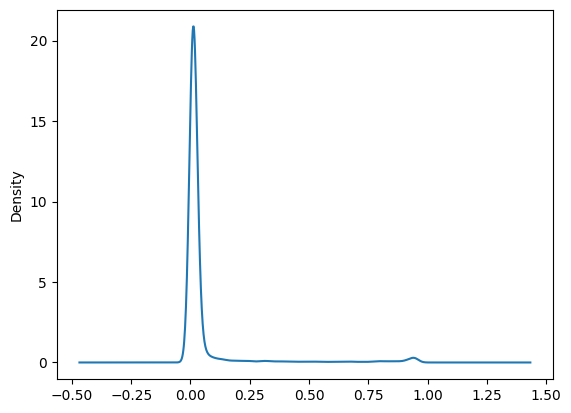

In [138]:
metadata['prob_1'].plot(kind='density')

In [122]:
metadata['prob_1'] = metadata['logits'].apply(lambda x: x[0][1].item())

In [125]:
metadata.sort_values('prob_1', ascending=False).head(10)

,platform,year,sentence,logits,prob_1
94340,Reddit,20210901,in addition to what is prohibited in the conte...,"[[tensor(0.0419), tensor(0.9581)]]",0.958058
94466,Reddit,20240201,in addition to what is prohibited in the conte...,"[[tensor(0.0421), tensor(0.9579)]]",0.957939
94586,Reddit,20230901,in addition to what is prohibited in the conte...,"[[tensor(0.0421), tensor(0.9579)]]",0.957939
94919,Reddit,20230601,in addition to what is prohibited in the conte...,"[[tensor(0.0421), tensor(0.9579)]]",0.957905
94235,Reddit,20180601,"when accessing or using our services , you wil...","[[tensor(0.0421), tensor(0.9579)]]",0.957874
94701,Reddit,20180901,"when accessing or using our services , you wil...","[[tensor(0.0421), tensor(0.9579)]]",0.957874
56256,FB,20090201,prohibited conduct by using or accessing [mask...,"[[tensor(0.0424), tensor(0.9576)]]",0.957594
100107,Snapchat,20230801,"that means , among other things , you may not ...","[[tensor(0.0426), tensor(0.9574)]]",0.957444
100663,Snapchat,20211101,"that means , among other things , you may not ...","[[tensor(0.0426), tensor(0.9574)]]",0.957437
101586,Snapchat,20210901,"that means , among other things , you may not ...","[[tensor(0.0426), tensor(0.9574)]]",0.957437


In [134]:
df_deduplicated = metadata.drop_duplicates(subset=['sentence'])
df_deduplicated['annotated'] = df_deduplicated.sentence.isin(df_annotations.text)
int_labels = [((0.95,1.0),'confident_positive'),( (0.80,.95), 'sure_positive'),((0.60,.80), 'leaning_positive'),
                   ((0.50,.60), 'borderline_positive'),((0.40,.50), 'borderline_negative'),
                   ((0.20,.40), 'leaning_negative'),((0.05,.20), 'sure_negative'),((0.0,.05), 'confident_negative')]
for interval, label in int_labels:


    df_deduplicated.loc[df_deduplicated.prob_1.between(*interval),'category']  = label



/var/folders/d2/ydv0grbd38985h6_95t0vdjw0000gp/T/ipykernel_37345/3514719801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduplicated['annotated'] = df_deduplicated.sentence.isin(df_annotations.text)
/var/folders/d2/ydv0grbd38985h6_95t0vdjw0000gp/T/ipykernel_37345/3514719801.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduplicated.loc[df_deduplicated.prob_1.between(*interval),'category']  = label


In [137]:
pd.concat([df_deduplicated[df_deduplicated.category == label].sample(10)
    for _ , label in int_labels], axis=0)[['sentence','category']].to_csv('annotations/automatic_annotations_by_category.csv')
